In [1]:
import pandas as pd
import numpy as np

* since the mean r2oos of other methods including elastic net, glm, pls, neural network are too small, we only did a dm test on gbrt and rf.

# recreate the train/validation/test split

In [2]:
# import pyarrow.feather as feather
import os
from datetime import datetime
from tqdm import tqdm


import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from collections import Counter

## read the feather files

In [3]:
import os
directory_path = os.getcwd()
print("My current directory is : " + directory_path)
folder_name = os.path.basename(directory_path)
print("My directory name is : " + folder_name)

My current directory is : /home/spectre/Desktop/summer_project/Summer-project-ML
My directory name is : Summer-project-ML


In [4]:
directory_path = os.getcwd()
data_path = os.path.join(directory_path, 'data')  # the path to data folder

In [5]:
raw_df = pd.read_feather(os.path.join(data_path, 'chars60_raw_imputed.feather'))

# save a industry adjusted market equity dataframe

In [6]:
me_df = raw_df[['date', 'permno', 'me']].copy()

## read the macro data files

In [7]:
macro_df = pd.read_csv(os.path.join(data_path, 'Macro.csv'))
macro_df = macro_df[macro_df['yyyymm']>=197201]

In [8]:
raw_df['yyyymm'] = raw_df['date'].dt.strftime("%Y%m").apply(int)
total_df = pd.merge(raw_df, macro_df, how='inner', on='yyyymm')
total_df.drop(columns="yyyymm", inplace=True)


In [9]:
raw_tf = total_df.isnull().any()
raw_tf.where(raw_tf == True).dropna().index.to_list()

[]

In [10]:
del(raw_tf)

In [11]:
# make a list of unique permno
permno_list = total_df['permno'].unique().tolist()

In [12]:
# need to turn some variables to dummy variables
def get_dummy_col(target_df, col_names):
    """turn the cols into multiple cols containing dummy variables, then drop the original columns

    Args:
        target_df (pandas dataframe): target dataframe
        col_names (list): list of columns that need to be turned into dummy variables
    """
    for col in col_names:        
        tmp_dummies = pd.get_dummies(target_df[col]).rename(columns=lambda x: f'{col}_' + str(x))
        target_df = pd.concat([target_df, tmp_dummies], axis=1)
        target_df.drop(col, inplace=True, axis = 1)
    return target_df 
dummy_col_list = ['ffi49']
total_df = get_dummy_col(total_df, dummy_col_list)

In [13]:
# set date as the index
total_df.set_index('date', inplace=True)

In [14]:
features_list = total_df.columns.to_list()
list_to_remove = ['gvkey', 'permno', 'ret', 'sic', 'exchcd', 'shrcd']
for element in list_to_remove:
    if element in features_list:
        features_list.remove(element)
        


In [15]:
original_features_list = features_list.copy()

In [16]:
total_df = total_df.sort_index()

# create interaction features(other feature * macro feature)

In [17]:
table_for_interaction = total_df[features_list[:69]]
single_features = features_list[:61]
macro_features = features_list[61:69]

interaction_table = pd.DataFrame(data = None, index = table_for_interaction.index)

from IPython.utils import io
with io.capture_output() as captured: # to ignore warnings
    for i in single_features:
        for j in macro_features:
            interaction_table[i + '+' + j] = table_for_interaction[i] * table_for_interaction[j]

In [18]:
each_month_permno_num = pd.DataFrame(Counter(total_df.reset_index().date).items(), columns=['date', 'number_of_permno'])
# each_month_permno_num.plot(x='date', y='number_of_permno')

In [19]:
new_total_df = pd.concat([total_df, interaction_table], axis=1)

In [20]:
new_features_list = new_total_df.columns
remove_list = {'gvkey', 'permno', 'ret','sic','exchcd','shrcd','b/m', 'tbl', 'ntis', 'svar', 'd/p', 'e/p', 'dfy', 'tms'}
new_features_list = [ele for ele in new_features_list if ele not in remove_list]

In [21]:
X_total = new_total_df[new_features_list]
y_total = new_total_df['ret']
permno_total = new_total_df['permno']

In [22]:
def train_val_test_preprocess(X_total, y_total, permno_total, training_len, val_len, testing_len):
    """split our data into training set, validation set, and testing set

    Args:
        X_total (dataframe)
        y_total (dataframe)
        training_len (int): length of years of training set
        val_len (int)
        testing_len (int)
    return: dicts:X_train, y_train, X_val, y_val, X_test, y_test
            and a permno series for testing set, which would be part of the result
    """
    X_train_dict = {}
    y_train_dict = {}
    X_val_dict = {}
    y_val_dict = {}
    X_test_dict = {}
    y_test_dict = {}
    permno_test_dict = {}
    first_train_end_year = y_total.index.year[0] + training_len - 1
    total_len = y_total.index.year[-1] - y_total.index.year[0] + 1
    last_train_end_year = first_train_end_year + total_len -(training_len+val_len+testing_len)
    train_end_years = np.arange(first_train_end_year, last_train_end_year+1)
    print('each end year of training set is:', train_end_years)
    for y in tqdm(train_end_years, desc='spliting data', ascii='>>'):
        train_start_year = y - training_len + 1
        train_end_year = y
        val_start_year = y + 1
        val_end_year = val_start_year+val_len-1
        test_start_year= val_end_year+1
        test_end_year = test_start_year+testing_len-1

        print('train start year is', train_start_year)
        print('train end year is', train_end_year)

        print('val start year is', val_start_year)
        print('val end year is', val_end_year)

        print('test start year is', test_start_year)
        print('test end year is', test_end_year)

        tmp_X_train = X_total[(X_total.index.year>=train_start_year) & (X_total.index.year<=train_end_year)]
        tmp_y_train = y_total[(y_total.index.year>=train_start_year) & (y_total.index.year<=train_end_year)]
        tmp_X_val = X_total[(X_total.index.year>=val_start_year) & (X_total.index.year<=val_end_year)]
        tmp_y_val = y_total[(y_total.index.year>=val_start_year) & (y_total.index.year<=val_end_year)]
        tmp_X_test = X_total[(X_total.index.year>=test_start_year) & (X_total.index.year<=test_end_year)]
        tmp_y_test = y_total[(y_total.index.year>=test_start_year) & (y_total.index.year<=test_end_year)]
        tmp_permno_test = permno_total[(permno_total.index.year>=test_start_year) & (permno_total.index.year<=test_end_year)]

        X_train_dict[y] = tmp_X_train
        y_train_dict[y] = tmp_y_train
        X_val_dict[y] = tmp_X_val
        y_val_dict[y] = tmp_y_val
        X_test_dict[y] = tmp_X_test
        y_test_dict[y] = tmp_y_test
        permno_test_dict[y] = tmp_permno_test
    return train_end_years, X_train_dict, y_train_dict, X_val_dict, y_val_dict, X_test_dict, y_test_dict, permno_test_dict
        

In [23]:
train_end_years, X_train_dict, y_train_dict, X_val_dict, y_val_dict, X_test_dict, y_test_dict, permno_test_dict = train_val_test_preprocess(X_total, y_total, permno_total, 14, 6, 26)


each end year of training set is: [1985 1986 1987 1988]


spliting data:   0%|>>>>>>>>>>| 0/4 [00:00<?, ?it/s]

train start year is 1972
train end year is 1985
val start year is 1986
val end year is 1991
test start year is 1992
test end year is 2017


spliting data:  25%|>>>>>>>>>>| 1/4 [00:00<00:02,  1.46it/s]

train start year is 1973
train end year is 1986
val start year is 1987
val end year is 1992
test start year is 1993
test end year is 2018


spliting data:  50%|>>>>>>>>>>| 2/4 [00:01<00:01,  1.45it/s]

train start year is 1974
train end year is 1987
val start year is 1988
val end year is 1993
test start year is 1994
test end year is 2019


spliting data:  75%|>>>>>>>>>>| 3/4 [00:02<00:00,  1.45it/s]

train start year is 1975
train end year is 1988
val start year is 1989
val end year is 1994
test start year is 1995
test end year is 2020


spliting data: 100%|>>>>>>>>>>| 4/4 [00:02<00:00,  1.42it/s]


----------------------------------------------------------

# preprocessing for dm_test
make the data more readable

In [24]:
for y in train_end_years:
    tmp_y_test = y_test_dict[y]
    print(tmp_y_test.index)

DatetimeIndex(['1992-01-31', '1992-01-31', '1992-01-31', '1992-01-31',
               '1992-01-31', '1992-01-31', '1992-01-31', '1992-01-31',
               '1992-01-31', '1992-01-31',
               ...
               '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31',
               '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31',
               '2017-12-31', '2017-12-31'],
              dtype='datetime64[ns]', name='date', length=238048, freq=None)
DatetimeIndex(['1993-01-31', '1993-01-31', '1993-01-31', '1993-01-31',
               '1993-01-31', '1993-01-31', '1993-01-31', '1993-01-31',
               '1993-01-31', '1993-01-31',
               ...
               '2018-12-31', '2018-12-31', '2018-12-31', '2018-12-31',
               '2018-12-31', '2018-12-31', '2018-12-31', '2018-12-31',
               '2018-12-31', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=235983, freq=None)
DatetimeIndex(['1994-01-31', '1994-01-31', '1994-01-31', '1994-01-

In [25]:
gbrt_result_df = pd.read_pickle('result_data/gbrt_testing26_basic_result.pkl')
rf_result_df = pd.read_pickle('result_data/rf_testing26_interaction_result_v2.pkl')


In [26]:
gbrt_result_df.columns

Index(['year', 'permno', 'y_pred', 'y_real', 'params', 'pred_R2_OOS', 'CV_R2',
       'CV_MSE'],
      dtype='object')

In [27]:
gbrt_result_df

,year,permno,y_pred,y_real,params,pred_R2_OOS,CV_R2,CV_MSE
0,1985,date 1992-01-31 18921 1992-01-31 24942 1...,"[0.011920158392580498, 0.011920158392580498, 0...",date 1992-01-31 -0.043182 1992-01-31 0.02...,"{'learning_rate': 0.021562931723419013, 'max_d...",0.018223,0.022267,"[-0.013831126103901779, -0.014578247824041698,..."
1,1986,date 1993-01-31 36003 1993-01-31 25718 1...,"[0.018214678094006915, 0.018880031439181478, 0...",date 1993-01-31 0.040816 1993-01-31 -0.09...,"{'learning_rate': 0.0381451978919721, 'max_dep...",-0.01106,-0.03039,"[-0.014603003301297716, -0.015257101075988995,..."
2,1987,date 1994-01-31 70229 1994-01-31 51625 1...,"[0.010905969728908293, 0.01179465440514668, 0....",date 1994-01-31 -0.015075 1994-01-31 0.00...,"{'learning_rate': 0.04507921868121577, 'max_de...",0.014846,0.0401,"[-0.011201063195763018, -0.011424846173905738,..."
3,1988,date 1995-01-31 44951 1995-01-31 72726 1...,"[0.015679737499026656, 0.014857237357482357, 0...",date 1995-01-31 -0.025641 1995-01-31 0.14...,"{'learning_rate': 0.017477747568997296, 'max_d...",0.035013,-0.018359,"[-0.015040252425560936, -0.013046038995863228,..."


In [28]:
rf_result_df

,year,permno,y_pred,y_real,params,pred_R2_OOS,CV_R2,CV_MSE
0,1985,date 1992-01-31 18921 1992-01-31 24942 1...,"[0.01463993982691722, 0.011966620468600699, 0....",date 1992-01-31 -0.043182 1992-01-31 0.02...,"{'max_depth': 4, 'max_features': 'log2', 'n_es...",0.043166,0.000015,"[-0.013179849821233458, -0.013471323278318681,..."
1,1986,date 1993-01-31 36003 1993-01-31 25718 1...,"[0.014965764300496311, 0.02279645801640643, 0....",date 1993-01-31 0.040816 1993-01-31 -0.09...,"{'max_depth': 3, 'max_features': 'log2', 'n_es...",0.038612,0.006401,"[-0.013392068616686329, -0.013250813069278215,..."
2,1987,date 1994-01-31 70229 1994-01-31 51625 1...,"[0.017104362145423307, 0.011303168397428343, 0...",date 1994-01-31 -0.015075 1994-01-31 0.00...,"{'max_depth': 5, 'max_features': 'log2', 'n_es...",0.043891,0.027088,"[-0.011329579055203147, -0.011689639812946068,..."
3,1988,date 1995-01-31 44951 1995-01-31 72726 1...,"[0.01932514557280454, 0.012747819943132076, 0....",date 1995-01-31 -0.025641 1995-01-31 0.14...,"{'max_depth': 7, 'max_features': 'log2', 'n_es...",0.055507,0.021096,"[-0.011683554083591452, -0.011168044239342142,..."


In [29]:
gbrt_result_df['year'].unique()

array([1985, 1986, 1987, 1988], dtype=object)

In [30]:
# tmp_y_real_series.index.duplicated().any()

In [31]:
def make_df_list(train_end_years, result_df):
    y_pred_df_list = []
    y_real_df_list = []
    for y in train_end_years:
        tmp_permno = pd.Series(result_df.loc[result_df['year'] == y, 'permno'].tolist()[0])
        tmp_y_pred_series = pd.Series(result_df.loc[result_df['year'] == y, 'y_pred'].to_list()[0])
        # print(len(tmp_y_pred_series))
        # tmp_y_real_series already has index
        tmp_y_real_series = pd.Series(result_df.loc[result_df['year'] == y, 'y_real'].to_list()[0])
        #add index to tmp_y_pred_series
        tmp_y_pred_series.index = tmp_y_real_series.index

        
        tmp_pred_df = pd.concat([tmp_permno, tmp_y_pred_series], axis=1)
        tmp_real_df = pd.concat([tmp_permno, tmp_y_real_series], axis=1)
        #reset_index
        tmp_pred_df.reset_index(drop=False, inplace=True)
        tmp_real_df.reset_index(drop=False, inplace=True)
        #rename the ret column
        tmp_pred_df.rename(columns = {0:f'ret_{y}'}, inplace = True)
        tmp_real_df.rename(columns = {'ret':f'ret_{y}'}, inplace = True)

        # print(len(tmp_y_real_series))
        y_pred_df_list.append(tmp_pred_df)
        y_real_df_list.append(tmp_real_df)
    return y_pred_df_list, y_real_df_list

In [32]:
gbrt_pred_df_list, gbrt_real_df_list = make_df_list(train_end_years, gbrt_result_df)
rf_pred_df_list, rf_real_df_list = make_df_list(train_end_years, rf_result_df)

In [33]:
gbrt_real_df_list[0].columns

Index(['date', 'permno', 'ret_1985'], dtype='object')

------------------------------------
# preprocessing for making portfolio For Random Forest

In [34]:
# merge all the dataframe together
merged_pred_df = pd.merge(rf_pred_df_list[0], rf_pred_df_list[1], on=['date', 'permno'], how='outer')
merged_pred_df = pd.merge(merged_pred_df, rf_pred_df_list[2], on=['date', 'permno'], how='outer')
merged_pred_df = pd.merge(merged_pred_df, rf_pred_df_list[3], on=['date', 'permno'], how='outer')

merged_real_df = pd.merge(rf_real_df_list[0], rf_real_df_list[1], on=['date', 'permno'], how='outer')
merged_real_df = pd.merge(merged_real_df, rf_real_df_list[2], on=['date', 'permno'], how='outer')
merged_real_df = pd.merge(merged_real_df, rf_real_df_list[3], on=['date', 'permno'], how='outer')


In [35]:
merged_pred_df['ret_ave'] = merged_pred_df[['ret_1985', 'ret_1986', 'ret_1987', 'ret_1988']].mean(axis=1)
merged_real_df['ret_ave'] = merged_real_df[['ret_1985', 'ret_1986', 'ret_1987', 'ret_1988']].mean(axis=1)

In [36]:
merged_pred_df

,date,permno,ret_1985,ret_1986,ret_1987,ret_1988,ret_ave
0,1992-01-31,18921,0.014640,NaN,NaN,NaN,0.014640
1,1992-01-31,24942,0.011967,NaN,NaN,NaN,0.011967
2,1992-01-31,46228,0.020178,NaN,NaN,NaN,0.020178
3,1992-01-31,14154,0.022688,NaN,NaN,NaN,0.022688
4,1992-01-31,91380,0.014422,NaN,NaN,NaN,0.014422
...,...,...,...,...,...,...,...
260338,2020-12-31,60986,NaN,NaN,NaN,0.023059,0.023059
260339,2020-12-31,21207,NaN,NaN,NaN,0.021008,0.021008
260340,2020-12-31,57665,NaN,NaN,NaN,0.018508,0.018508
260341,2020-12-31,57817,NaN,NaN,NaN,0.022357,0.022357


# preprocessing for making portfolio For GBRT

In [37]:
# merge all the dataframe together
merged_pred_df_gbrt = pd.merge(gbrt_pred_df_list[0], gbrt_pred_df_list[1], on=['date', 'permno'], how='outer')
merged_pred_df_gbrt = pd.merge(merged_pred_df_gbrt, gbrt_pred_df_list[2], on=['date', 'permno'], how='outer')
merged_pred_df_gbrt = pd.merge(merged_pred_df_gbrt, gbrt_pred_df_list[3], on=['date', 'permno'], how='outer')

merged_real_df_gbrt = pd.merge(gbrt_real_df_list[0], gbrt_real_df_list[1], on=['date', 'permno'], how='outer')
merged_real_df_gbrt = pd.merge(merged_real_df_gbrt, gbrt_real_df_list[2], on=['date', 'permno'], how='outer')
merged_real_df_gbrt = pd.merge(merged_real_df_gbrt, gbrt_real_df_list[3], on=['date', 'permno'], how='outer')

In [38]:
merged_pred_df_gbrt['ret_ave'] = merged_pred_df_gbrt[['ret_1985', 'ret_1986', 'ret_1987', 'ret_1988']].mean(axis=1)
merged_real_df_gbrt['ret_ave'] = merged_real_df_gbrt[['ret_1985', 'ret_1986', 'ret_1987', 'ret_1988']].mean(axis=1)

In [39]:
merged_pred_df_gbrt

,date,permno,ret_1985,ret_1986,ret_1987,ret_1988,ret_ave
0,1992-01-31,18921,0.01192,NaN,NaN,NaN,0.011920
1,1992-01-31,24942,0.01192,NaN,NaN,NaN,0.011920
2,1992-01-31,46228,0.01192,NaN,NaN,NaN,0.011920
3,1992-01-31,14154,0.01192,NaN,NaN,NaN,0.011920
4,1992-01-31,91380,0.01192,NaN,NaN,NaN,0.011920
...,...,...,...,...,...,...,...
260338,2020-12-31,60986,NaN,NaN,NaN,0.014906,0.014906
260339,2020-12-31,21207,NaN,NaN,NaN,0.015153,0.015153
260340,2020-12-31,57665,NaN,NaN,NaN,0.015153,0.015153
260341,2020-12-31,57817,NaN,NaN,NaN,0.014857,0.014857


In [40]:
merged_pred_df

,date,permno,ret_1985,ret_1986,ret_1987,ret_1988,ret_ave
0,1992-01-31,18921,0.014640,NaN,NaN,NaN,0.014640
1,1992-01-31,24942,0.011967,NaN,NaN,NaN,0.011967
2,1992-01-31,46228,0.020178,NaN,NaN,NaN,0.020178
3,1992-01-31,14154,0.022688,NaN,NaN,NaN,0.022688
4,1992-01-31,91380,0.014422,NaN,NaN,NaN,0.014422
...,...,...,...,...,...,...,...
260338,2020-12-31,60986,NaN,NaN,NaN,0.023059,0.023059
260339,2020-12-31,21207,NaN,NaN,NaN,0.021008,0.021008
260340,2020-12-31,57665,NaN,NaN,NaN,0.018508,0.018508
260341,2020-12-31,57817,NaN,NaN,NaN,0.022357,0.022357


# Construct Porftolio

In [41]:
# delete all the unnecessary data
del(each_month_permno_num)
del(element)
del(features_list)
del(gbrt_pred_df_list)
del(gbrt_real_df_list)
del(gbrt_result_df)
del(interaction_table)
del(macro_df)
del(macro_features)
del(original_features_list)
del(permno_list)
del(permno_test_dict)
del(permno_total)
del(rf_result_df)
del(tmp_y_test)
del(remove_list)
del(raw_df)
del(new_features_list)
del(new_total_df)
del(list_to_remove)
del(captured)
del(rf_pred_df_list)
del(rf_real_df_list)
del(table_for_interaction)
del(total_df)
del(X_test_dict)
del(X_total)
del(X_train_dict)
del(X_val_dict)
del(y_test_dict)
del(y_total)
del(y_train_dict)
del(y_val_dict)
del(single_features)

In [42]:
# For benchmark S&P500
import yfinance

sp500_data = yfinance.download(tickers = "^GSPC", start = "1991-12-31", end = "2021-01-01", interval = "1d")
# monthly return for s&p500
sp500_m_adj_close = sp500_data['Adj Close'].resample('M').ffill()
sp500_m_ret = sp500_m_adj_close.pct_change()[1:]

[*********************100%***********************]  1 of 1 completed


In [43]:
pred_ave_ret_df = merged_pred_df[['date', 'permno', 'ret_ave']]
pred_ave_ret_df.set_index('date', inplace=True)


In [44]:
real_ret_df = merged_real_df[['date', 'permno', 'ret_ave']]
real_ret_df.set_index('date', inplace=True)
real_ret_df = real_ret_df.rename(columns={'ret_ave':'ret'})


In [45]:
pred_ave_ret_df

,permno,ret_ave
date,,
1992-01-31,18921,0.014640
1992-01-31,24942,0.011967
1992-01-31,46228,0.020178
1992-01-31,14154,0.022688
1992-01-31,91380,0.014422
...,...,...
2020-12-31,60986,0.023059
2020-12-31,21207,0.021008
2020-12-31,57665,0.018508


*for the long part: we select the top 50 permnos that have the biggest average return, and weight them according to their market equity*

*for the short part: we select the bottom 50 permnos that have the smallest average return, and weight them according to their market equity*

In [46]:
long_ports = pred_ave_ret_df.groupby('date').apply(lambda x: x.sort_values('ret_ave', ascending=False)).groupby('date')['permno'].head(50)
short_ports = pred_ave_ret_df.groupby('date').apply(lambda x: x.sort_values('ret_ave', ascending=True)).groupby('date')['permno'].head(50)

In [47]:
long_ports

date
1992-01-31    18278
1992-01-31    13290
1992-01-31    48565
1992-01-31    54447
1992-01-31    41515
              ...  
2020-12-31    71175
2020-12-31    75573
2020-12-31    84032
2020-12-31    46886
2020-12-31    84519
Name: permno, Length: 17400, dtype: int64

In [48]:
# # download the price data
# import datetime as dt
# import wrds
# from dateutil.relativedelta import *
# from pandas.tseries.offsets import *
# import pyarrow.feather as feather
# import sqlite3
# # permno_list = pd.read_csv('s&p500_permno.txt', header=None, dtype='str')
# # permno_list = tuple(permno_list.iloc[:,0].tolist())
# ###################
# # Connect to WRDS #
# ###################
# conn = wrds.Connection()

In [49]:
# permno_array = np.append(long_ports.unique(), short_ports.unique())
# permno_list = tuple(permno_array)

In [50]:
# permno_list

In [51]:

# crsp = conn.raw_sql("""
#                     select permno, date, prc
#                     from crsp.dsf
#                     where permno in {}
#                     and date >= '01/01/1972'
#                     """.format(permno_list))

In [52]:
# crsp.set_index('date', inplace=True)

# set the transaction cost to be 2%

In [53]:
transaction_cost = 0.02

# apply the selected permno

In [54]:
me_df.set_index('date', inplace=True)

In [55]:
# me_df['weight'] = me_df.me/me_df.me.sum()

In [56]:
me_df = me_df[me_df.index >= pd.Timestamp('1992-01-01')]

In [57]:
long_ports

date
1992-01-31    18278
1992-01-31    13290
1992-01-31    48565
1992-01-31    54447
1992-01-31    41515
              ...  
2020-12-31    71175
2020-12-31    75573
2020-12-31    84032
2020-12-31    46886
2020-12-31    84519
Name: permno, Length: 17400, dtype: int64

In [58]:
me_df

,permno,me
date,,
1992-01-31,50906,3.474754e+05
1992-02-29,50906,3.513640e+05
1992-03-31,50906,3.479855e+05
1992-04-30,50906,3.851490e+05
1992-05-31,50906,3.694010e+05
...,...,...
2019-08-31,90272,1.445212e+07
2019-09-30,90272,1.362147e+07
2019-10-31,90272,1.303936e+07


calculate the weight

In [59]:
me_long_df = pd.DataFrame()
me_short_df = pd.DataFrame()
for day in me_df.index.unique():
    tmp_long_permno = long_ports[long_ports.index == day]
    tmp_short_permno = short_ports[short_ports.index == day]
    for p in me_df.loc[day, 'permno']:
        if p in tmp_long_permno.values:
            me_long_df = pd.concat([me_long_df, me_df[(me_df.index == day) 
                & (me_df['permno'] == p)]])
        if p in tmp_short_permno.values:
            me_short_df = pd.concat([me_short_df, me_df[(me_df.index == day) 
                & (me_df['permno'] == p)]])

In [60]:
me_long_df

,permno,me
date,,
1992-01-31,18980,4.353188e+04
1992-01-31,45911,1.855250e+04
1992-01-31,15974,1.515375e+04
1992-01-31,85631,8.553585e+05
1992-01-31,58480,1.888898e+05
...,...,...
2013-12-31,90547,1.475986e+06
2013-12-31,90664,2.375333e+06
2013-12-31,91611,5.948501e+06


In [61]:
# select the target permno of each month 

In [62]:
m_long_sum_me_df = me_long_df.groupby('date')['me'].sum()
m_short_sum_me_df = me_short_df.groupby('date')['me'].sum()

In [63]:
for day in m_long_sum_me_df.index.unique():
    me_long_df.loc[day, "weight"] = me_long_df.loc[day, 'me'] / m_long_sum_me_df[day]


for day in m_short_sum_me_df.index.unique():
    me_short_df.loc[day, "weight"] = me_short_df.loc[day, 'me'] / m_short_sum_me_df[day]

In [64]:
#check
me_long_df.weight.groupby('date').sum()

date
1992-01-31    1.0
1992-02-29    1.0
1992-03-31    1.0
1992-04-30    1.0
1992-05-31    1.0
             ... 
2020-08-31    1.0
2020-09-30    1.0
2020-10-31    1.0
2020-11-30    1.0
2020-12-31    1.0
Name: weight, Length: 348, dtype: float64

In [65]:
me_long_df

,permno,me,weight
date,,,
1992-01-31,18980,4.353188e+04,0.002669
1992-01-31,45911,1.855250e+04,0.001137
1992-01-31,15974,1.515375e+04,0.000929
1992-01-31,85631,8.553585e+05,0.052436
1992-01-31,58480,1.888898e+05,0.011580
...,...,...,...
2013-12-31,90547,1.475986e+06,0.006845
2013-12-31,90664,2.375333e+06,0.011015
2013-12-31,91611,5.948501e+06,0.027585


calculate the transaction cost

In [75]:
def calc_cost(df, t_cost):
#calculate the transaction cost
    transaction_cost = []
    tmp_count = 0
    for d in df.index.unique():
        last_d = d
        if tmp_count == 0:
            transaction_cost.append(t_cost)
            tmp_count = 1
        else:
            shared_permno = np.intersect1d(df[df.index == last_d]['permno'], df[df.index == d]['permno'])

            shared_weight = 0
            for p in shared_permno:
                shared_weight += min(df[(df.index == d) & (df['permno'] == p)]['weight'].values[0],
                                       df[(df.index == last_d) & (df['permno'] == p)]['weight'].values[0])
            tmp_cost = 2*(1-shared_weight) * t_cost
            transaction_cost.append(tmp_cost)
            last_d = d
    return transaction_cost
            

In [76]:
long_t_cost = calc_cost(me_long_df, transaction_cost)
short_t_cost = calc_cost(me_short_df, transaction_cost)

In [77]:
long_ports_ret_for_each_permno = pd.DataFrame()
for d, p in zip(long_ports.index, long_ports.values):
    tmp_long = real_ret_df.loc[(real_ret_df.index==d) & (real_ret_df.permno==p)].copy()
    tmp_long['ret'] = tmp_long['ret'].values[0] * me_long_df.loc[(me_long_df.index==d) & (me_long_df.permno==p)]['weight'].values[0]
    long_ports_ret_for_each_permno = pd.concat([long_ports_ret_for_each_permno, tmp_long])

short_ports_ret_for_each_permno = pd.DataFrame()
for d, p in zip(short_ports.index, short_ports.values):
    tmp_short = real_ret_df.loc[(real_ret_df.index==d) & (real_ret_df.permno==p)].copy()
    tmp_short['ret'] = tmp_short['ret'].values[0] * me_short_df.loc[(me_short_df.index==d) & (me_short_df.permno==p)]['weight'].values[0]
    short_ports_ret_for_each_permno = pd.concat([short_ports_ret_for_each_permno, tmp_short])



In [79]:
long_ports_ret_for_each_permno

,permno,ret
date,,
1992-01-31,18278,0.000074
1992-01-31,13290,0.000003
1992-01-31,48565,0.003299
1992-01-31,54447,0.000127
1992-01-31,41515,0.001490
...,...,...
2020-12-31,71175,0.000487
2020-12-31,75573,0.000112
2020-12-31,84032,0.001922


calculate the monthly return

In [81]:
long_ports_ret = long_ports_ret_for_each_permno.groupby('date')['ret'].apply('sum')
short_ports_ret = short_ports_ret_for_each_permno.groupby('date')['ret'].apply('sum')*(-1)
# add the transaction cost
long_ports_ret = long_ports_ret - long_t_cost
short_ports_ret = short_ports_ret - short_t_cost
long_short_ports_ret = (long_ports_ret + short_ports_ret)/2

In [82]:
long_ports_cumu_ret = (long_ports_ret+1).cumprod() - 1
short_ports_cumu_ret = (short_ports_ret+1).cumprod() - 1
long_short_cumu_ret = (long_short_ports_ret+1).cumprod() - 1
sp500_m_cumu_ret = (sp500_m_ret+1).cumprod() - 1

In [83]:
short_ports_cumu_ret

date
1992-01-31    0.021358
1992-02-29    0.027577
1992-03-31    0.053548
1992-04-30    0.033789
1992-05-31    0.022909
                ...   
2020-08-31   -0.663171
2020-09-30   -0.648788
2020-10-31   -0.630395
2020-11-30   -0.699878
2020-12-31   -0.713618
Name: ret, Length: 348, dtype: float64

# Repeat  for GBRT

In [85]:
pred_ave_ret_df_gbrt = merged_pred_df_gbrt[['date', 'permno', 'ret_ave']]
pred_ave_ret_df_gbrt.set_index('date', inplace=True)

real_ret_df = merged_real_df_gbrt[['date', 'permno', 'ret_ave']]
real_ret_df.set_index('date', inplace=True)
real_ret_df = real_ret_df.rename(columns={'ret_ave':'ret'})

long_ports_gbrt = pred_ave_ret_df_gbrt.groupby('date').apply(lambda x: x.sort_values('ret_ave', ascending=False)).groupby('date')['permno'].head(50)
short_ports_gbrt = pred_ave_ret_df_gbrt.groupby('date').apply(lambda x: x.sort_values('ret_ave', ascending=True)).groupby('date')['permno'].head(50)


me_long_df_gbrt = pd.DataFrame()
me_short_df_gbrt = pd.DataFrame()

for day in me_df.index.unique():
    tmp_long_permno = long_ports_gbrt[long_ports.index == day]
    tmp_short_permno = short_ports_gbrt[short_ports.index == day]
    for p in me_df.loc[day, 'permno']:
        if p in tmp_long_permno.values:
            me_long_df_gbrt = pd.concat([me_long_df_gbrt, me_df[(me_df.index == day) 
                & (me_df['permno'] == p)]])
        if p in tmp_short_permno.values:
            me_short_df_gbrt = pd.concat([me_short_df_gbrt, me_df[(me_df.index == day) 
                & (me_df['permno'] == p)]])
m_long_sum_me_df_gbrt = me_long_df_gbrt.groupby('date')['me'].sum()
m_short_sum_me_df_gbrt = me_short_df_gbrt.groupby('date')['me'].sum()

for day in m_long_sum_me_df_gbrt.index.unique():
    me_long_df_gbrt.loc[day, "weight"] = me_long_df_gbrt.loc[day, 'me'] / m_long_sum_me_df_gbrt[day]


for day in m_short_sum_me_df_gbrt.index.unique():
    me_short_df_gbrt.loc[day, "weight"] = me_short_df_gbrt.loc[day, 'me'] / m_short_sum_me_df_gbrt[day]

long_t_cost_gbrt = calc_cost(me_long_df_gbrt, transaction_cost)
short_t_cost_gbrt = calc_cost(me_short_df_gbrt, transaction_cost)

long_ports_ret_for_each_permno_gbrt = pd.DataFrame()
for d, p in zip(long_ports_gbrt.index, long_ports_gbrt.values):
    tmp_long = real_ret_df.loc[(real_ret_df.index==d) & (real_ret_df.permno==p)].copy()
    tmp_long['ret'] = tmp_long['ret'].values[0] * me_long_df_gbrt.loc[(me_long_df_gbrt.index==d) & (me_long_df_gbrt.permno==p)]['weight'].values[0]
    long_ports_ret_for_each_permno_gbrt = pd.concat([long_ports_ret_for_each_permno_gbrt, tmp_long])

short_ports_ret_for_each_permno_gbrt = pd.DataFrame()
for d, p in zip(short_ports_gbrt.index, short_ports_gbrt.values):
    tmp_short = real_ret_df.loc[(real_ret_df.index==d) & (real_ret_df.permno==p)].copy()
    tmp_short['ret'] = tmp_short['ret'].values[0] * me_short_df_gbrt.loc[(me_short_df_gbrt.index==d) & (me_short_df_gbrt.permno==p)]['weight'].values[0]
    short_ports_ret_for_each_permno_gbrt = pd.concat([short_ports_ret_for_each_permno_gbrt, tmp_short])


In [86]:
long_ports_ret_for_each_permno_gbrt

,permno,ret
date,,
1992-01-31,18921,-0.000437
1992-01-31,45751,-0.001122
1992-01-31,18980,0.000009
1992-01-31,21020,0.000053
1992-01-31,27991,0.000202
...,...,...
2020-12-31,35044,0.000502
2020-12-31,15408,0.001095
2020-12-31,84372,0.000664


In [87]:
long_ports_ret_gbrt = long_ports_ret_for_each_permno_gbrt.groupby('date')['ret'].apply('sum')
short_ports_ret_gbrt = short_ports_ret_for_each_permno_gbrt.groupby('date')['ret'].apply('sum')*(-1)
# add the transaction cost
long_ports_ret_gbrt = long_ports_ret_gbrt - long_t_cost_gbrt
short_ports_ret_gbrt = short_ports_ret_gbrt - short_t_cost_gbrt
long_short_ports_ret_gbrt = (long_ports_ret_gbrt + short_ports_ret_gbrt)/2

long_ports_cumu_ret_gbrt = (long_ports_ret_gbrt+1).cumprod() - 1
short_ports_cumu_ret_gbrt = (short_ports_ret_gbrt+1).cumprod() - 1
long_short_cumu_ret_gbrt = (long_short_ports_ret_gbrt+1).cumprod() - 1


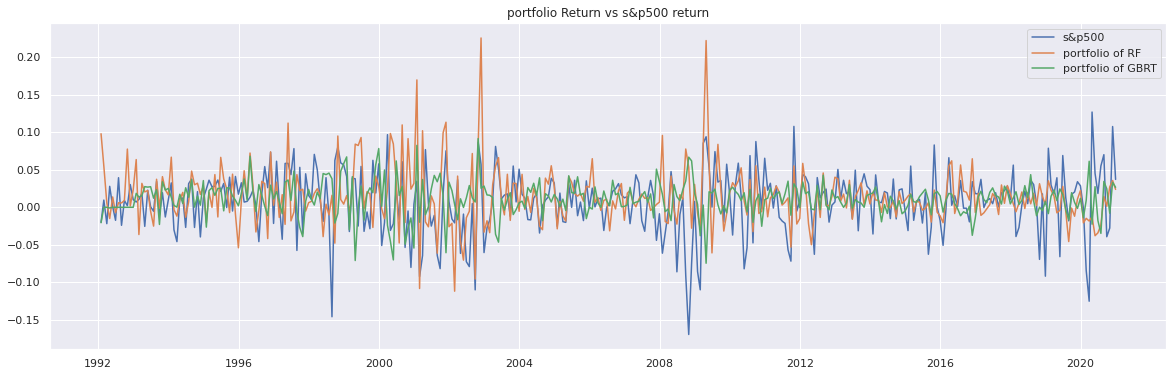

In [88]:
plt.figure(figsize=(20,6))
plt.title('portfolio Return vs s&p500 return')
plt.plot(sp500_m_ret, label='s&p500')
plt.plot(long_short_ports_ret, label='portfolio of RF')
plt.plot(long_short_ports_ret_gbrt, label='portfolio of GBRT')
plt.legend()
plt.show()

In [89]:
# log-return
log_long_ports_cumu_ret = np.log(long_ports_ret+1).cumsum() 
log_short_ports_cumu_ret = np.log(short_ports_ret+1).cumsum() 
log_long_short_cumu_ret = np.log(long_short_ports_ret+1).cumsum() 
log_sp500_m_cumu_ret = np.log(sp500_m_ret+1).cumsum() 

log_long_ports_cumu_ret_gbrt = np.log(long_ports_ret_gbrt+1).cumsum() 
log_short_ports_cumu_ret_gbrt = np.log(short_ports_ret_gbrt+1).cumsum() 
log_long_short_cumu_ret_gbrt = np.log(long_short_ports_ret_gbrt+1).cumsum() 

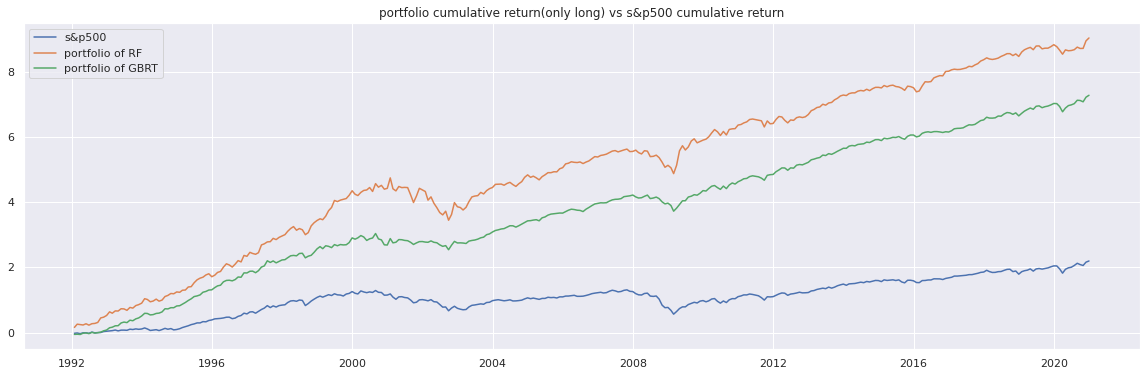

In [90]:
plt.figure(figsize=(20,6))
plt.title('portfolio cumulative return(only long) vs s&p500 cumulative return')
plt.plot(log_sp500_m_cumu_ret, label='s&p500')
plt.plot(log_long_ports_cumu_ret, label='portfolio of RF')
plt.plot(log_long_ports_cumu_ret_gbrt, label='portfolio of GBRT')
plt.legend()
plt.show()

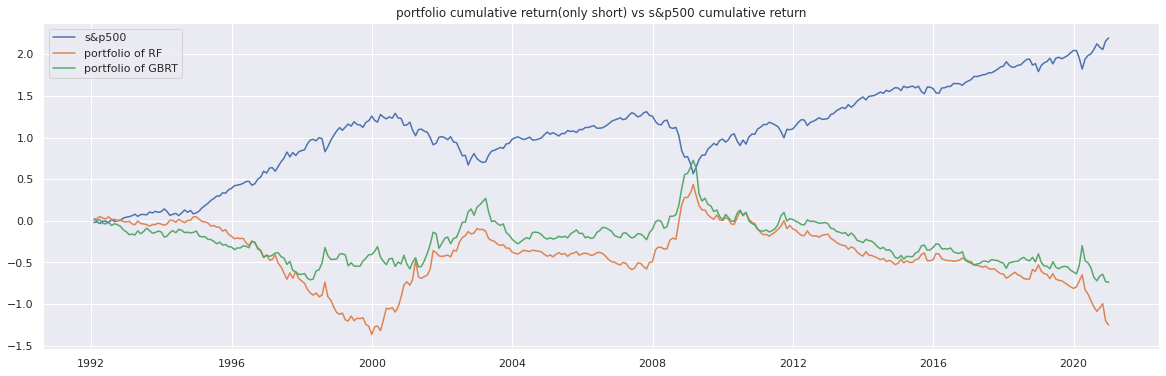

In [91]:
plt.figure(figsize=(20,6))
plt.title('portfolio cumulative return(only short) vs s&p500 cumulative return')
plt.plot(log_sp500_m_cumu_ret, label='s&p500')
plt.plot(log_short_ports_cumu_ret, label='portfolio of RF')
plt.plot(log_short_ports_cumu_ret_gbrt, label='portfolio of GBRT')
plt.legend()
plt.show()

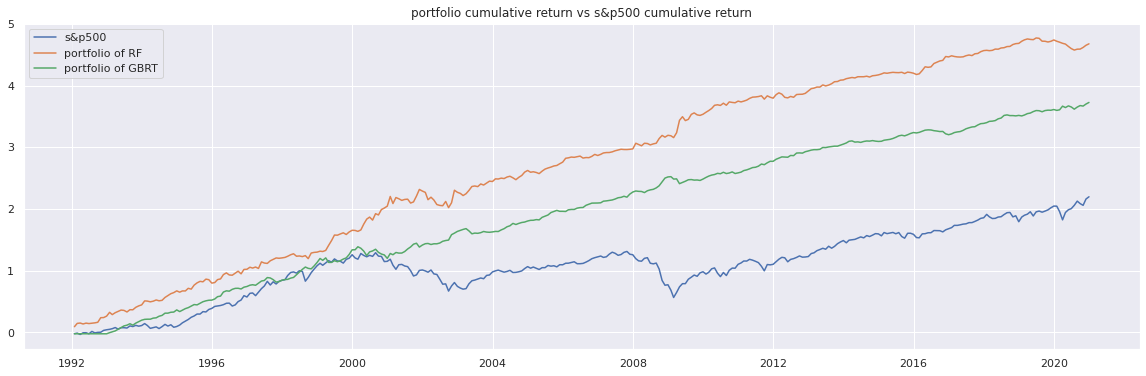

In [92]:
plt.figure(figsize=(20,6))
plt.title('portfolio cumulative return vs s&p500 cumulative return')
plt.plot(log_sp500_m_cumu_ret, label='s&p500')
plt.plot(log_long_short_cumu_ret, label='portfolio of RF')
plt.plot(log_long_short_cumu_ret_gbrt, label='portfolio of GBRT')
plt.legend()
plt.show()

compute the sharpe ratio(annualized)

In [104]:
# random forest 
sr_rf = log_long_short_cumu_ret[-1]/len(log_long_short_cumu_ret)/np.log(long_short_ports_ret+1).std() * np.sqrt(12)
print('the sharpe ratio for long short portfolio based on the result of random forest is:', sr_rf)
# gbrt
sr_gbrt = log_long_ports_cumu_ret_gbrt[-1]/len(log_long_ports_cumu_ret_gbrt)/np.log(long_short_ports_ret_gbrt+1).std() * np.sqrt(12)
print('the sharpe ratio for long short portfolio based on the result of gbrt is:', sr_gbrt)

the sharpe ratio for long short portfolio based on the result of random forest is: 1.2695205681637975
the sharpe ratio for long short portfolio based on the result of gbrt is: 3.275391996765069


compute the information ratio(annualized) with the benchmark of S&P500 index

In [106]:
# random forest
ir_rf = (log_long_short_cumu_ret[-1] - log_sp500_m_cumu_ret[-1])/len(log_long_short_cumu_ret)/(np.log(long_short_ports_ret+1) - np.log(sp500_m_ret+1)).std() * np.sqrt(12)
print('the information ratio for long short portfolio based on the result of random forest is:', ir_rf)

ir_gbrt = (log_long_ports_cumu_ret_gbrt[-1] - log_sp500_m_cumu_ret[-1])/len(log_long_ports_cumu_ret_gbrt)/(np.log(long_short_ports_ret_gbrt+1) - np.log(sp500_m_ret+1)).std() * np.sqrt(12)
print('the information ratio for long short portfolio based on the result of gbrt is:', ir_gbrt)

the information ratio for long short portfolio based on the result of random forest is: 0.5304460177732925
the information ratio for long short portfolio based on the result of gbrt is: 1.0488539239774186


calculate the maximum drawdown

In [110]:
def calc_max_drawdown(cumu_ret) -> float:
    return np.min(cumu_ret / cumu_ret.expanding().max()) - 1

In [114]:
max_dd_rf = calc_max_drawdown(long_short_cumu_ret)
max_dd_gbrt = calc_max_drawdown(long_short_cumu_ret_gbrt)
print('the maximum drawdown of long short portfolio based on the result of random forest is', max_dd_rf)
print('the maximum drawdown of long short portfolio based on the result of gbrt is', max_dd_gbrt)

the maximum drawdown of long short portfolio based on the result of random forest is -0.2835522528753782
the maximum drawdown of long short portfolio based on the result of gbrt is -0.2288343010199927


--------------------
# other stuff

###  Compute Accuracy

In [93]:
tp_df = pred_ave_ret_df.copy()
tp_df['ret'] = real_ret_df['ret']

In [94]:
tp_df

,permno,ret_ave,ret
date,,,
1992-01-31,18921,0.014640,-0.043182
1992-01-31,24942,0.011967,0.028571
1992-01-31,46228,0.020178,-0.153846
1992-01-31,14154,0.022688,-0.037500
1992-01-31,91380,0.014422,-0.033962
...,...,...,...
2020-12-31,60986,0.023059,-0.001411
2020-12-31,21207,0.021008,0.024991
2020-12-31,57665,0.018508,0.052301


In [80]:
import heapq
# for each month, lable top-30% return stock as 1, middle as 0, and bottom-30% return as -1 based on real return
date_list = tp_df.index.drop_duplicates()
tp_df_result_adj = pd.DataFrame()

for i in tqdm(date_list):
    df = tp_df[tp_df.index == i]
    df=df.assign(type = '')
    real_y_list = df['ret'].to_list()
    
    top = heapq.nlargest(round(0.3 * len(real_y_list)), real_y_list)
    bottom = heapq.nsmallest(round(0.3 * len(real_y_list)), real_y_list)
    
    for j in range(len(df['ret'])):
        if df.iloc[j,df.columns.get_loc('ret')] in top:
            df.iloc[j,df.columns.get_loc('type')] = 1
        elif df.iloc[j,df.columns.get_loc('ret')] in bottom:
            df.iloc[j,df.columns.get_loc('type')] = -1
        else:
            df.iloc[j,df.columns.get_loc('type')] = 0
            
    tp_df_result_adj = tp_df_result_adj.append(df)

  0%|          | 0/348 [00:00<?, ?it/s]/tmp/ipykernel_86613/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/tmp/ipykernel_86613/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
  1%|          | 2/348 [00:00<00:22, 15.08it/s]/tmp/ipykernel_86613/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/tmp/ipykernel_86613/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
  1%|          | 4/348 [00:00<

In [81]:
tp_df_result_adj

,permno,ret_ave,ret,type
date,,,,
1992-01-31,18921,0.014640,-0.043182,-1
1992-01-31,24942,0.011967,0.028571,0
1992-01-31,46228,0.020178,-0.153846,-1
1992-01-31,14154,0.022688,-0.037500,-1
1992-01-31,91380,0.014422,-0.033962,0
...,...,...,...,...
2020-12-31,60986,0.023059,-0.001411,-1
2020-12-31,21207,0.021008,0.024991,0
2020-12-31,57665,0.018508,0.052301,0


In [82]:
# build long and shor portfolio, long top 100 stock and short bottom 100 each month based on predicted return 
long_portfolio = tp_df_result_adj.groupby(level='date').apply(lambda x: x.sort_values('ret_ave', ascending=False).head(100))
short_portfolio = tp_df_result_adj.groupby(level='date').apply(lambda x: x.sort_values('ret_ave', ascending=True).head(100))

long_portfolio = long_portfolio.reset_index(level=0, drop=True)
short_portfolio = short_portfolio.reset_index(level=0, drop=True)

In [83]:
# check stock allocation accuracy for long portfolio 
print(f"The probability of a top stock been allocated in a long portfolio: {sum(long_portfolio['type']==1) / len(long_portfolio)}")
print(f"The probability of a middle stock been allocated in a long portfolio: {sum(long_portfolio['type']==0) / len(long_portfolio)}")
print(f"The probability of a bottom stock been allocated in a long portfolio: {sum(long_portfolio['type']==-1) / len(long_portfolio)}")

The probability of a top stock been allocated in a long portfolio: 0.3873563218390805
The probability of a middle stock been allocated in a long portfolio: 0.28109195402298853
The probability of a bottom stock been allocated in a long portfolio: 0.33155172413793105


In [84]:
# check stock allocation accuracy for short portfolio 
print(f"The probability of a top stock been allocated in a short portfolio: {sum(short_portfolio['type']==1) / len(short_portfolio)}")
print(f"The probability of a middle stock been allocated in a short portfolio: {sum(short_portfolio['type']==0) / len(short_portfolio)}")
print(f"The probability of a bottom stock been allocated in a short portfolio: {sum(short_portfolio['type']==-1) / len(short_portfolio)}")

The probability of a top stock been allocated in a short portfolio: 0.23824712643678161
The probability of a middle stock been allocated in a short portfolio: 0.4506034482758621
The probability of a bottom stock been allocated in a short portfolio: 0.31114942528735634
